
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Maximiliano Ramírez Núñez

**Rol**: 201710507-0

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import warnings
import timeit

warnings.filterwarnings("ignore")

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(20,30)})
%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [6]:
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


65


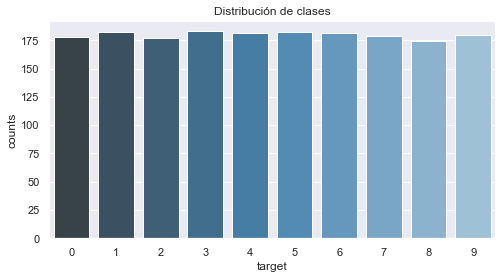

In [7]:
print(len(digits.columns))
gr = digits.groupby(['target']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='target', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Distribución de clases')
plt.show()
print("")

Notamos que todas las clases están distribuidad uniformemente

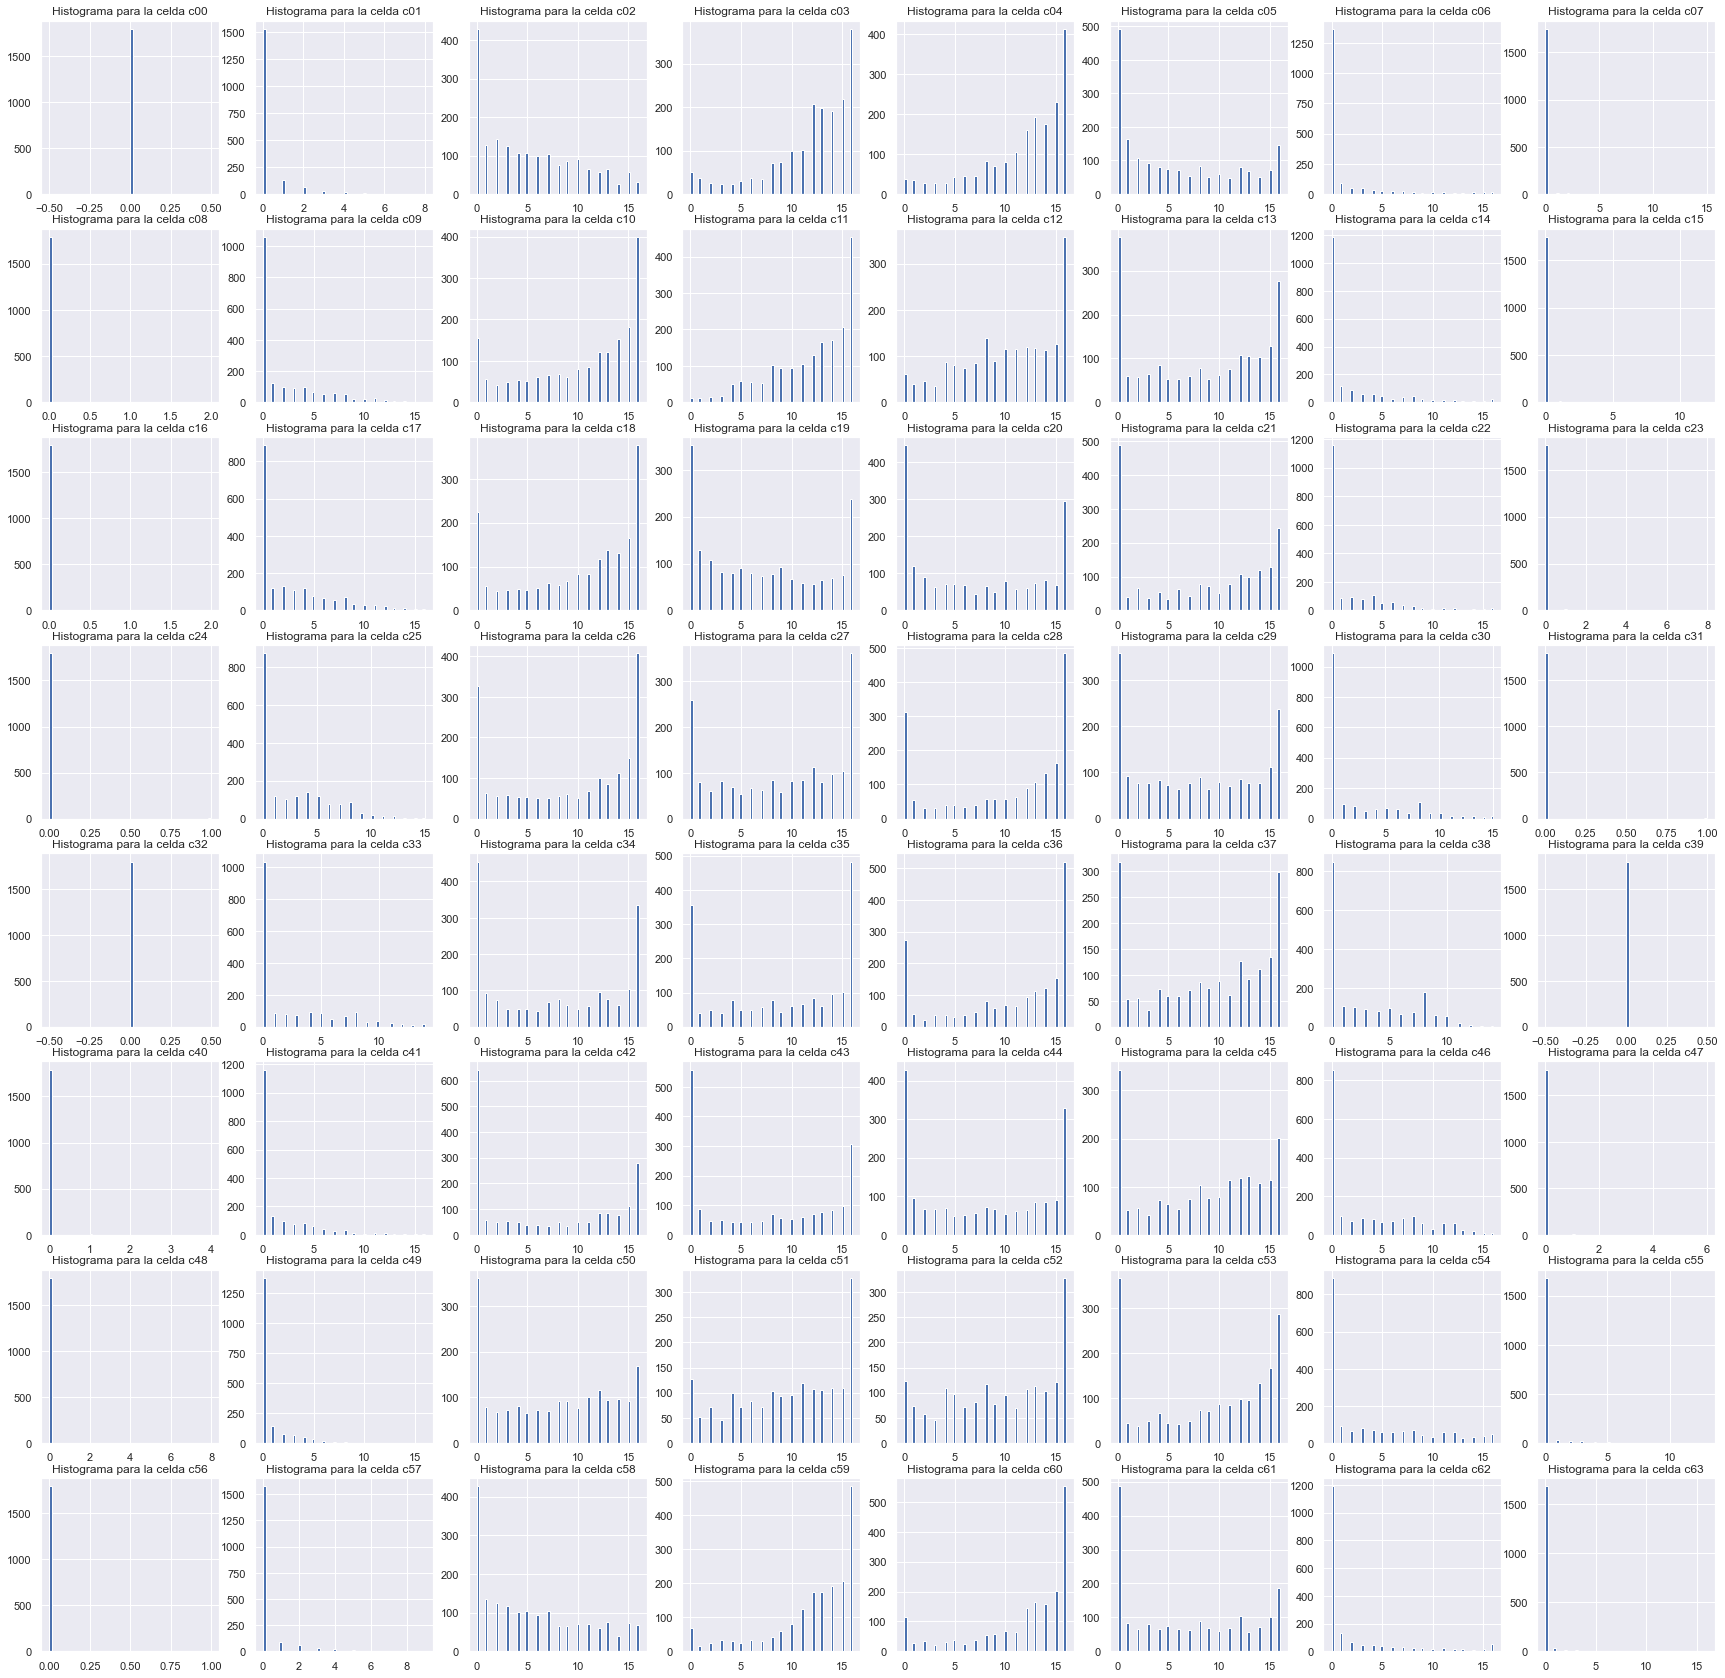

In [8]:
df=digits.drop(['target'],axis=1) #df sin target
figure(num=None, figsize=(30, 30)) #Ajustamos nuestra ventana de ploteo
k=1 #Establesemos un contador para el ploteo.
for i in df.columns: #recorrer columnas para generar histogramas
    plt.subplot(8,8,k)
    plt.hist(df[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    k+=1

plt.show()

In [9]:
#Memoria utilizada 456.4 KB

digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int32
 1   c01     1797 non-null   int32
 2   c02     1797 non-null   int32
 3   c03     1797 non-null   int32
 4   c04     1797 non-null   int32
 5   c05     1797 non-null   int32
 6   c06     1797 non-null   int32
 7   c07     1797 non-null   int32
 8   c08     1797 non-null   int32
 9   c09     1797 non-null   int32
 10  c10     1797 non-null   int32
 11  c11     1797 non-null   int32
 12  c12     1797 non-null   int32
 13  c13     1797 non-null   int32
 14  c14     1797 non-null   int32
 15  c15     1797 non-null   int32
 16  c16     1797 non-null   int32
 17  c17     1797 non-null   int32
 18  c18     1797 non-null   int32
 19  c19     1797 non-null   int32
 20  c20     1797 non-null   int32
 21  c21     1797 non-null   int32
 22  c22     1797 non-null   int32
 23  c23     1797 

In [10]:
#Tipos de datos
digits.dtypes.unique()

array([dtype('int32')], dtype=object)

In [11]:
#Todos tienen la misma cantidad de elementos
digits.describe().T['count'].unique()

array([1797.])

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [12]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

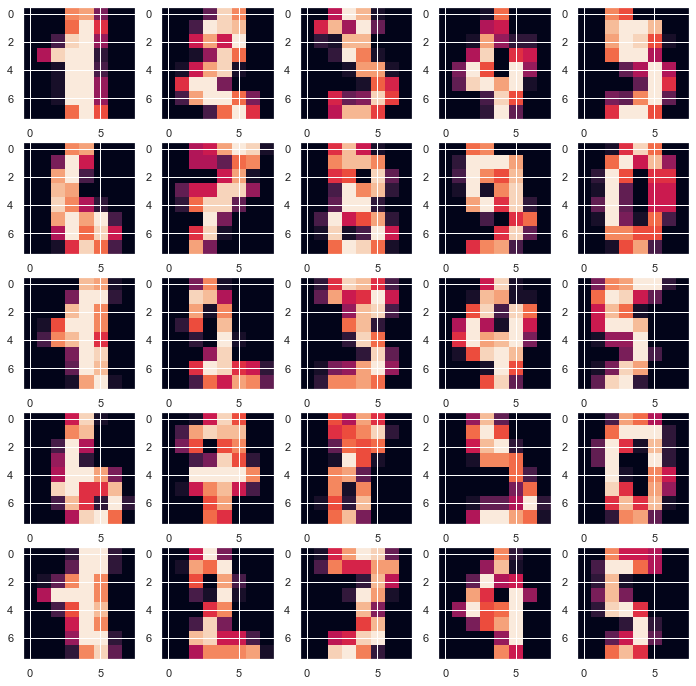

In [13]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))

for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(digits_dict["images"][i])

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [14]:
X = digits.drop(columns="target").values
y = digits["target"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Largo Train: ", X_train.shape)
print("Largo Test: ", X_test.shape)

Largo Train:  (1437, 64)
Largo Test:  (360, 64)


# Regresión Logística

In [16]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[1, 10]}
reg = LogisticRegression()
gs = GridSearchCV(reg, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.954063 con {'C': 1, 'penalty': 'l2'}


In [17]:
#Entrenar modelo
clf = LogisticRegression(penalty='l2', C=1)
clf.fit(X_train, y_train)

#Predicción
y_pred= clf.predict(X_test)

#Evaluar
confusion_matrix(y_test, y_pred)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 44,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 38]], dtype=int64)

In [19]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    0.96552   1.00000   0.98246        28
    numero 2    0.97059   1.00000   0.98507        33
    numero 3    0.97059   0.97059   0.97059        34
    numero 4    1.00000   0.95652   0.97778        46
    numero 5    0.91667   0.93617   0.92632        47
    numero 6    0.94444   0.97143   0.95775        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    0.96667   0.96667   0.96667        30
    numero 9    0.97436   0.95000   0.96203        40

    accuracy                        0.96944       360
   macro avg    0.97088   0.97220   0.97137       360
weighted avg    0.96994   0.96944   0.96952       360



# KNN

In [20]:
parameters = {'n_neighbors':[1, 10]}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.986082 con {'n_neighbors': 1}


In [21]:
#Entrenar modelo
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

#Predicción
y_pred= clf.predict(X_test)

#Evaluar
confusion_matrix(y_test, y_pred)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 34,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 28,  1],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0, 37]], dtype=int64)

In [22]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    0.93333   1.00000   0.96552        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    0.97143   1.00000   0.98551        34
    numero 4    0.97826   0.97826   0.97826        46
    numero 5    0.97872   0.97872   0.97872        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    1.00000   0.93333   0.96552        30
    numero 9    0.94872   0.92500   0.93671        40

    accuracy                        0.97778       360
   macro avg    0.97827   0.97859   0.97812       360
weighted avg    0.97816   0.97778   0.97771       360



# SVM

In [23]:
from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf'), 'C':range(10)}
sv = svm.SVC()
gs = GridSearchCV(sv, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.991655 con {'C': 7, 'kernel': 'rbf'}


In [24]:
from sklearn.svm import SVC

#Entrenar modelo
clf = SVC(kernel= 'rbf', C=7)
%timeit clf.fit(X_train, y_train)

#Predicción
y_pred= clf.predict(X_test)

#Evaluar
confusion_matrix(y_test, y_pred)

66.5 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 39]], dtype=int64)

In [25]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    1.00000   1.00000   1.00000        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    1.00000   0.97059   0.98507        34
    numero 4    1.00000   1.00000   1.00000        46
    numero 5    0.95833   0.97872   0.96842        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    0.97059   0.97059   0.97059        34
    numero 8    1.00000   0.96667   0.98305        30
    numero 9    0.97500   0.97500   0.97500        40

    accuracy                        0.98611       360
   macro avg    0.98761   0.98616   0.98681       360
weighted avg    0.98630   0.98611   0.98613       360



### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

**Se selecciona SVC como mejor modelo**

In [26]:
from sklearn.model_selection import cross_val_score

svm_best = svm.SVC(kernel='rbf', C=10)
scores = cross_val_score(svm_best, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.03)


## Curva de validación

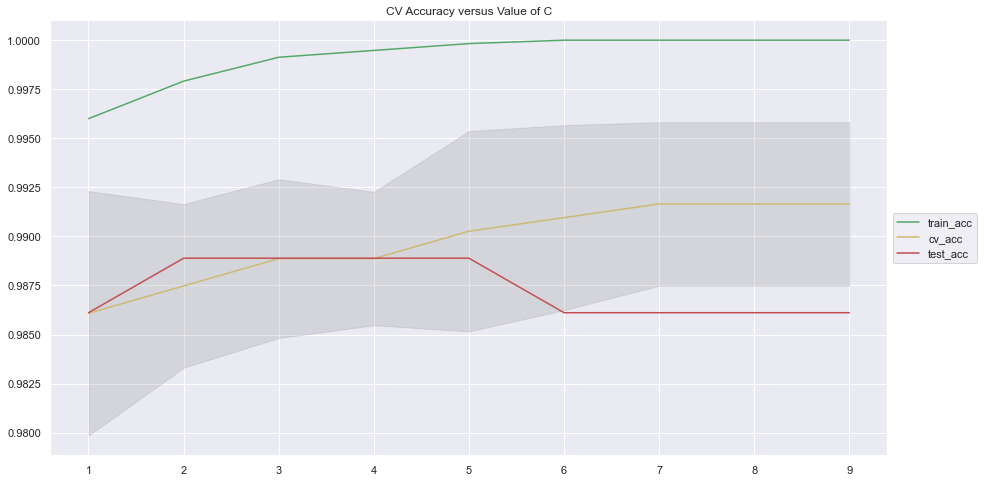

In [27]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


parameters = {'kernel':['rbf'], 'C': np.arange(1,10)}
svm = SVC()
gs = GridSearchCV(svm, parameters,return_train_score=True)
gs.fit(X_train,y_train)
C_values= np.arange(1,10)
test_accuracy = []
for C_val in C_values:
    svm = SVC(kernel='rbf', C=C_val)
    svm.fit(X_train,y_train)
    test_accuracy.append(svm.score(X_test,y_test))


fig, ax = plt.subplots(figsize=(15,8))
ax.plot(C_values,gs.cv_results_['mean_train_score'],color='g',lw=1.5,label='train_acc')
ax.plot(C_values,gs.cv_results_['mean_test_score'],color='y',lw=1.5,label='cv_acc')
ax.plot(C_values,test_accuracy,color='r',lw=1.5,label='test_acc')
plt.fill_between(C_values, gs.cv_results_['mean_test_score']-gs.cv_results_['std_test_score'], gs.cv_results_['mean_test_score']+gs.cv_results_['std_test_score'],color='gray', alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

La conclusión del gráfico es que el mejor parámetro C correspondería a $C=4$, pues es el que cumple la regla de la menor desviación estándar, lo que coincide con un buen score para un conjunto de test, a diferencia de la elección de gridsearch de $C=7$, donde se ve que el score para el conjunto de test no es tan bueno.

## Curva ROC

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from itertools import cycle

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

%matplotlib inline



# Binarize the output
y = label_binarize(y, classes=[i for i in range(10)])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='rbf', C=4, probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

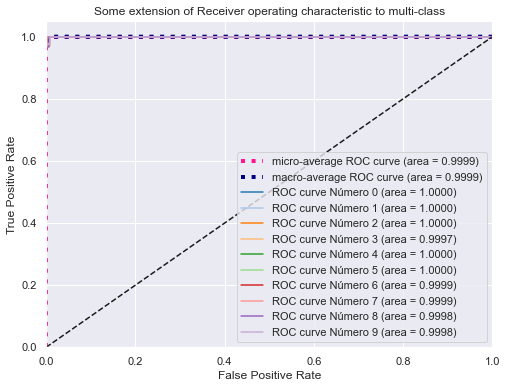

In [29]:
import matplotlib.colors

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle([plt.cm.tab20(i) for i in range(10)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve Número {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

En general todas las categorías de números a predecir son bien predichas por el modelo, con un accuracy bastante bueno. Los caso en los que existen errores, sin ambargo, muy pocos, son los casos en 3 y 8 por ejemplo, esto podría explicarse debido a la forma parecida de los números. Al igual que con el 6 y el 9. 

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


## Selección de atributos (selectKBest)

In [103]:
#escogemos las 40 caracteristicas más explicativas.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

X_training = digits.drop('target',axis=1)
y_training = digits['target']

columnas = list(X_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=40).fit(X_training, y_training) 

#Se escogen 40 ya que hay aproximadamente 20 atributos que son sólamente ceros, y se espera que el método los reconozca como
#no importantes

catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
atributos

['c02',
 'c03',
 'c05',
 'c06',
 'c09',
 'c10',
 'c13',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c25',
 'c26',
 'c27',
 'c28',
 'c29',
 'c30',
 'c33',
 'c34',
 'c35',
 'c36',
 'c37',
 'c38',
 'c41',
 'c42',
 'c43',
 'c44',
 'c45',
 'c46',
 'c50',
 'c51',
 'c52',
 'c53',
 'c54',
 'c58',
 'c59',
 'c60',
 'c61',
 'c62']

In [62]:
df_selec= digits[atributos]

In [104]:
#estadísticas
import statsmodels.api as sm

model = sm.OLS(digits['target'], sm.add_constant(df_selec))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     58.81
Date:                Mon, 21 Dec 2020   Prob (F-statistic):          1.74e-290
Time:                        19:39:16   Log-Likelihood:                -3677.3
No. Observations:                1797   AIC:                             7437.
Df Residuals:                    1756   BIC:                             7662.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4662      0.394      6.253      0.0

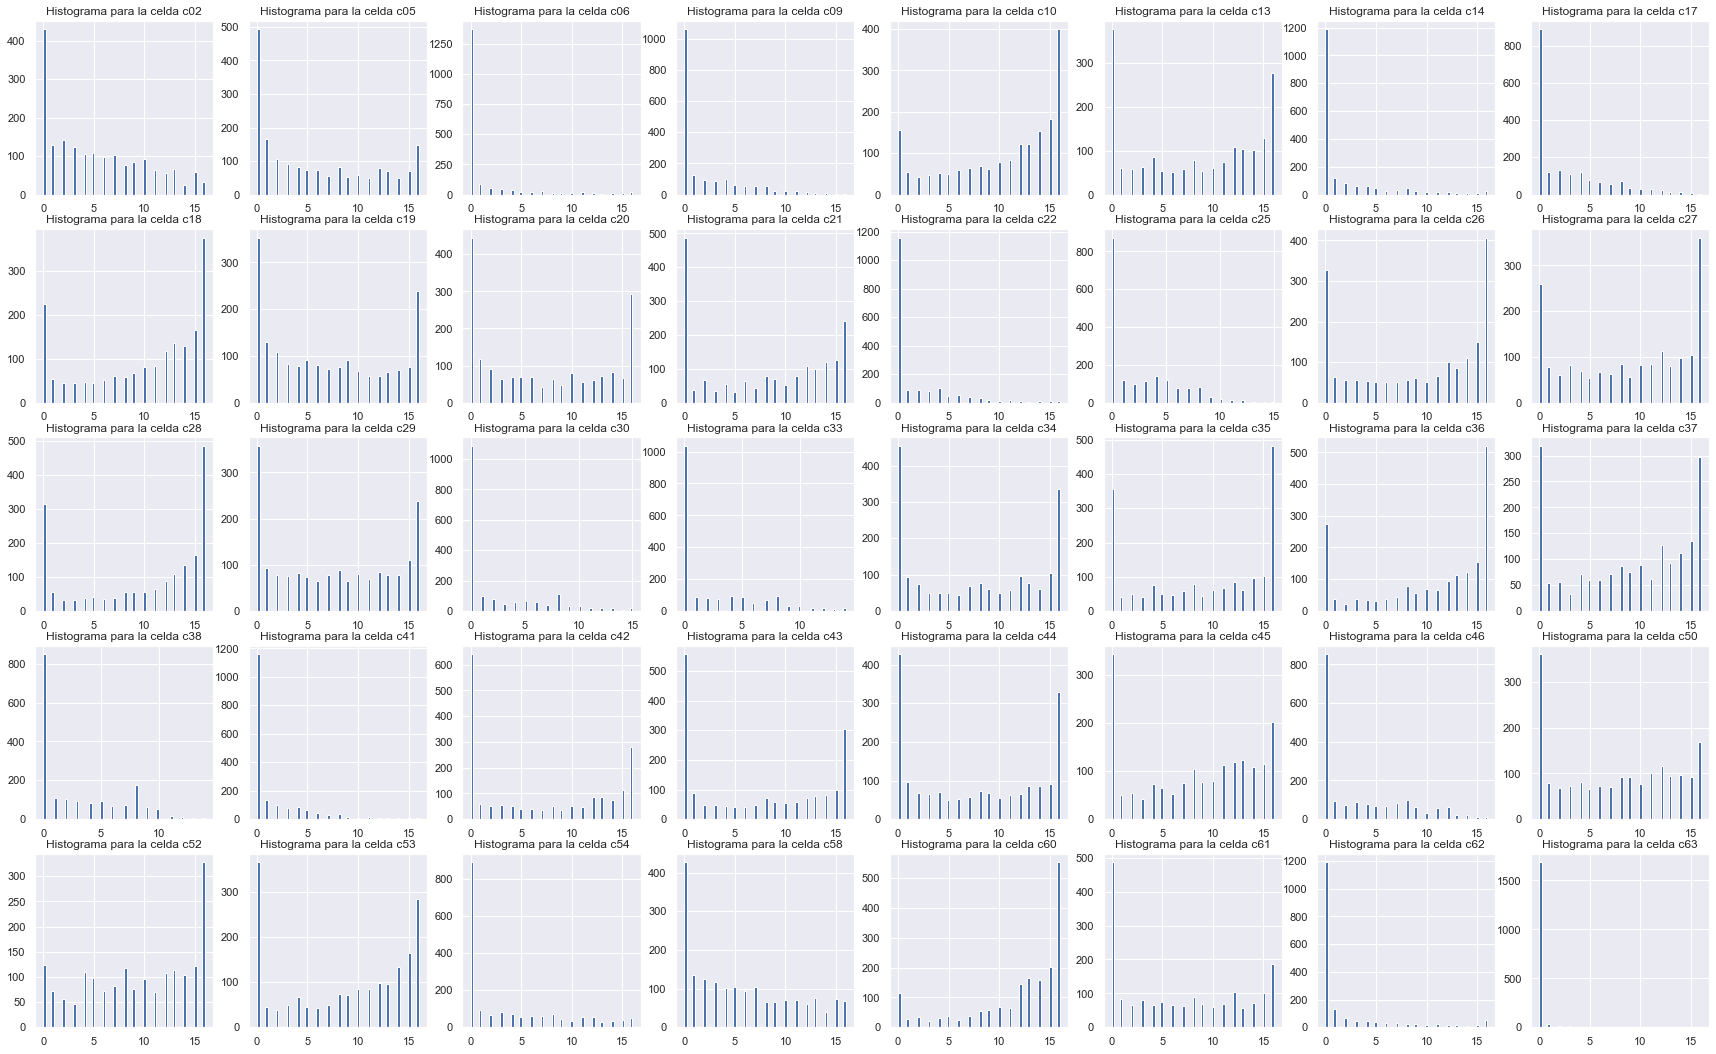

In [105]:
figure(num=None, figsize=(30, 30)) #Ajustamos nuestra ventana de ploteo
k=1 #Establesemos un contador para el ploteo.
for i in df_selec.columns: #recorrer columnas para generar histogramas
    plt.subplot(8,8,k)
    plt.hist(df[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    k+=1

plt.show()

In [106]:
total_original = digits.drop(['target'],axis=1).shape[0]*digits.drop(['target'],axis=1).shape[1]
total_nuevo = df_selec.shape[0]*df_selec.shape[1]

df_comparar = pd.DataFrame(columns=['Df', 'counts'])
df_comparar.loc[0]= ['Original',total_original]
df_comparar.loc[1]= ['Nuevo',total_nuevo]

In [107]:
df_comparar

,Df,counts
0,Original,115008
1,Nuevo,71880


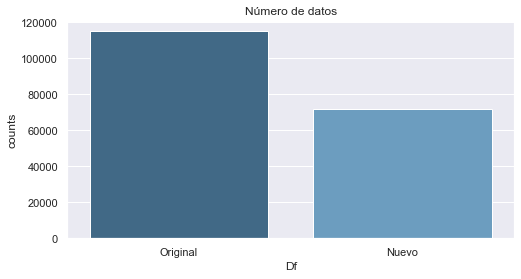

La cantidad de datos del DataFrame original es: 115008
La cantidad de datos del DataFrame despues de la selección es: 71880


In [108]:
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=df_comparar, x='Df', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Número de datos')
plt.show()
print("La cantidad de datos del DataFrame original es:", total_original)
print("La cantidad de datos del DataFrame despues de la selección es:", total_nuevo)

In [112]:
#comparamos con el primer modelo, Kernel='rbf, C=7

#Entrenar modelo
clf_2 = SVC(kernel= 'rbf', C=7)
print("Tiempo de ejecución del modelo")
%timeit  clf_2.fit(X_train_2, y_train_2)

#Predicción
y_pred_2= clf_2.predict(X_test_2)

#Evaluar
confusion_matrix(y_test_2, y_pred_2)

Tiempo de ejecución del modelo
58.9 ms ± 6.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 47,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 39]], dtype=int64)

In [113]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test_2, y_pred_2, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    1.00000   1.00000   1.00000        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    1.00000   0.97059   0.98507        34
    numero 4    0.97872   1.00000   0.98925        46
    numero 5    0.95918   1.00000   0.97917        47
    numero 6    1.00000   1.00000   1.00000        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    1.00000   0.96667   0.98305        30
    numero 9    0.97500   0.97500   0.97500        40

    accuracy                        0.98889       360
   macro avg    0.99129   0.98828   0.98966       360
weighted avg    0.98917   0.98889   0.98890       360



Resulta ser levemente más rápido (diferencia muy poco significativa). Y se obtiene una mejora en el accuracy

## Extracción de atributos (PCA)

In [114]:
#Escalamiento de los datos

from sklearn.preprocessing import StandardScaler

features = X_training.columns

X_escal = StandardScaler().fit_transform(X)

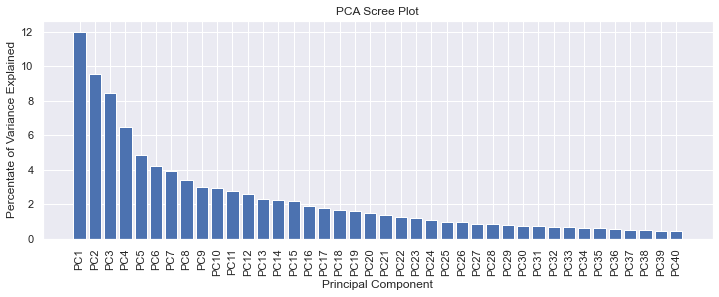

In [115]:
# ajustar modelo
from sklearn.decomposition import PCA
n=40
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(X_escal)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC'+ str(i) for i in range(1,n+1)]

plt.figure(figsize=(12,4))
plt.bar(x= range(1,n+1), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.xticks(rotation=90)
plt.show()

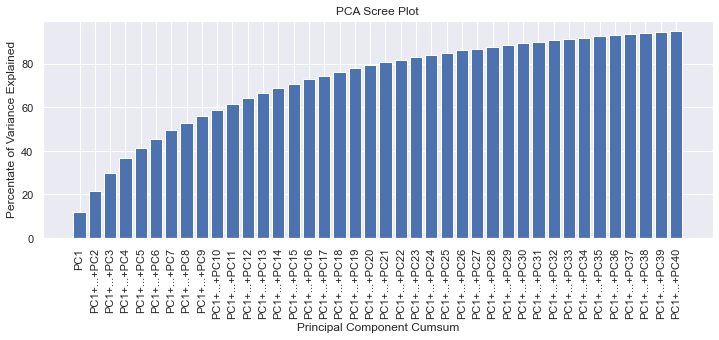

In [116]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns = ['PC1' + '+...+' + 'PC' + str(i) for i in range(2,n+1)]
columns.insert(0, 'PC1')

plt.figure(figsize=(12,4))
plt.bar(x= range(1,n+1), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.xticks(rotation=90)
plt.show()

In [117]:
percent_variance_cum

array([12.03, 21.59, 30.03, 36.53, 41.39, 45.6 , 49.54, 52.93, 55.93,
       58.86, 61.64, 64.22, 66.5 , 68.73, 70.9 , 72.81, 74.59, 76.23,
       77.83, 79.32, 80.67, 81.94, 83.11, 84.17, 85.15, 86.09, 86.95,
       87.79, 88.59, 89.34, 90.07, 90.76, 91.41, 92.05, 92.64, 93.21,
       93.73, 94.21, 94.66, 95.08])

notamos que si tomamos las primeras $40$ componentes principales, podemos explicar las demás variables del modelo en un 95.1% 

In [118]:
pca = PCA(n_components=40)

principalComponents = pca.fit_transform(X)

principalDataframe = pd.DataFrame(data = principalComponents, columns = ['PC'+str(i) for i in range(1,41)])
targetDataframe = digits[['target']]

newDataframe = pd.concat([principalDataframe, targetDataframe],axis = 1)
newDataframe.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,target
0,-1.259466,21.274883,-9.463055,13.014189,-7.128823,-7.440659,3.252837,2.553470,-0.581842,3.625697,...,-0.755026,0.162843,-2.112962,1.094826,0.195680,-0.089972,-2.763703,1.088923,0.206112,0
1,7.957611,-20.768699,4.439506,-14.893664,5.896249,-6.485622,2.126228,-4.615936,3.587450,-1.074705,...,1.290906,-2.154407,0.166807,3.191429,-1.532268,-3.688112,2.073792,-0.230844,0.722360,1
2,6.991923,-9.955986,2.958558,-12.288302,-18.126023,-4.507664,1.843122,-16.415200,0.719233,4.255805,...,0.450451,0.341084,-0.505626,-2.808247,-1.253868,-0.220581,0.038179,1.108628,3.285119,2
3,-15.906105,3.332464,9.824372,-12.275838,6.965169,1.089483,-1.042085,10.973556,-3.259735,6.498753,...,2.086400,3.220693,-0.826724,-1.392379,2.075339,-1.291332,1.963140,1.893077,0.675714,3
4,23.306867,4.269061,-5.675129,-13.851524,-0.358124,-2.857574,-0.720497,13.041696,-3.835413,13.414164,...,0.405446,-0.079859,1.284015,1.015916,3.805722,0.627330,-0.159856,-2.986677,-0.397595,4


In [119]:
#Estadisticas para PCA

model_pca = sm.OLS(targetDataframe, sm.add_constant(principalDataframe))
results = model_pca.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     61.41
Date:                Mon, 21 Dec 2020   Prob (F-statistic):          6.96e-300
Time:                        19:44:38   Log-Likelihood:                -3654.8
No. Observations:                1797   AIC:                             7392.
Df Residuals:                    1756   BIC:                             7617.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4908      0.044    101.752      0.0

In [120]:
#Crear dataframe para PCA

total_nuevo_pca = principalComponents.shape[0]*principalComponents.shape[1]

df_comparar_pca = pd.DataFrame(columns=['Df', 'counts'])
df_comparar_pca.loc[0]= ['Original',total_original]
df_comparar_pca.loc[1]= ['Nuevo',total_nuevo_pca]

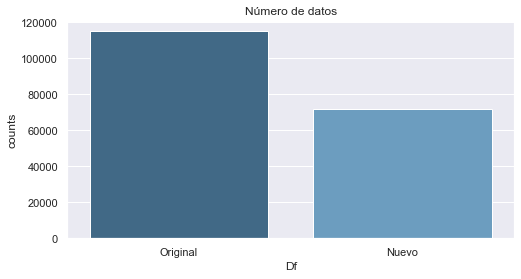

La cantidad de datos del DataFrame original es: 115008
La cantidad de datos del DataFrame despues de la selección es: 71880


In [121]:
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=df_comparar_pca, x='Df', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Número de datos')
plt.show()
print("La cantidad de datos del DataFrame original es:", total_original)
print("La cantidad de datos del DataFrame despues de la selección es:", total_nuevo_pca)

In [122]:
X_pca= principalComponents
y_pca= targetDataframe

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=.2,
                                                    random_state=42)

In [123]:
#Entrenar modelo
clf_pca = SVC(kernel= 'rbf', C=7)
print("Tiempo de ejecución del modelo")
%timeit  clf_pca.fit(X_train_pca, y_train_pca)

#Predicción
y_pred_pca= clf_pca.predict(X_test_pca)

#Evaluar
confusion_matrix(y_test_pca, y_pred_pca)

Tiempo de ejecución del modelo
65.6 ms ± 955 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 39]], dtype=int64)

In [124]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test_pca, y_pred_pca, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    1.00000   1.00000   1.00000        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    1.00000   0.97059   0.98507        34
    numero 4    1.00000   1.00000   1.00000        46
    numero 5    0.97872   0.97872   0.97872        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    0.97059   0.97059   0.97059        34
    numero 8    1.00000   1.00000   1.00000        30
    numero 9    0.97500   0.97500   0.97500        40

    accuracy                        0.98889       360
   macro avg    0.98965   0.98949   0.98953       360
weighted avg    0.98897   0.98889   0.98889       360



tiene un tiempo de ejecución practicamente igual al modelo original, y obtiene un accuracy ligeramente mejor

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [125]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    Y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = Y_pred == Y_test
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = Y_pred != Y_test
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(Y_test)[mask]
    y_aux_pred = np.array(Y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


In [126]:
modelo = SVC(kernel= 'rbf', C=4) # Mejor modelo

### Correctos

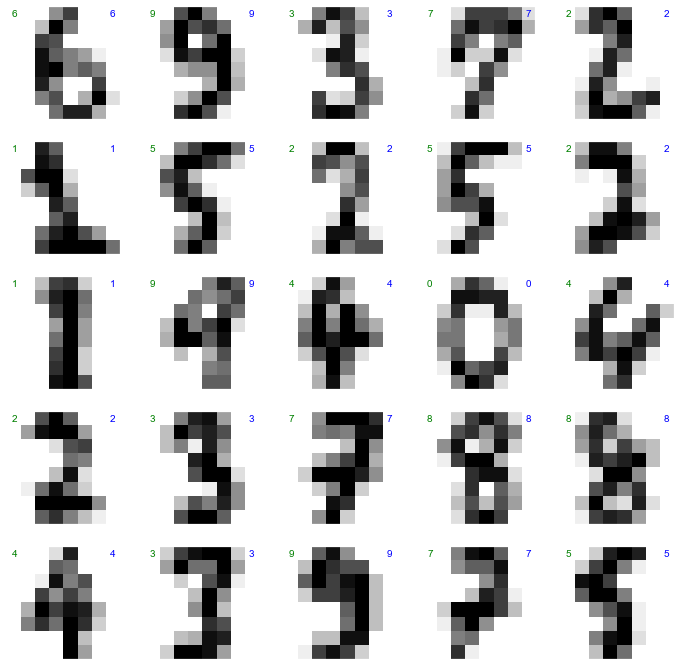

In [127]:
mostar_resultados(digits,modelo,nx=5, ny=5,label = "correctos")

### Incorrectos

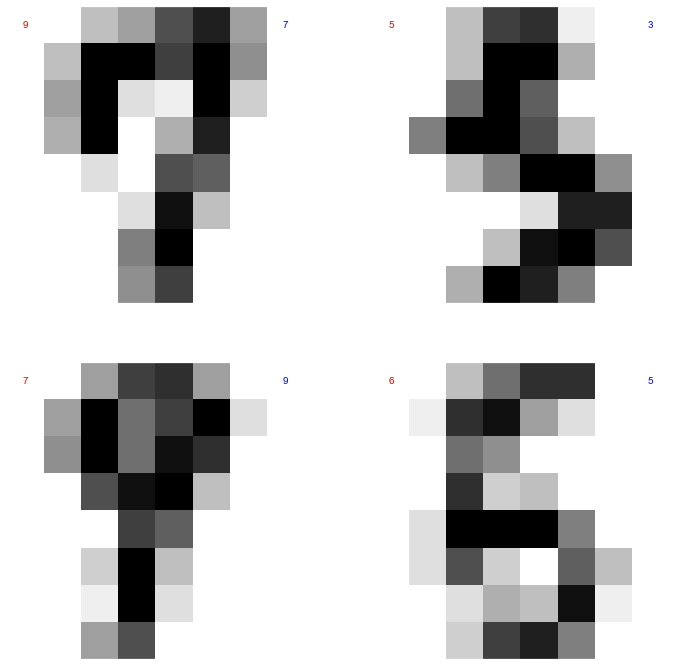

In [128]:
mostar_resultados(digits,modelo,nx=2, ny=2,label = "incorrectos")


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

ya que visualmente los valores supuestamente verdaderos, generan mucha confusión con otros números, por ejemplo, el que tiene como valor real 5, visualmente parece un 6. Llevando esto a SVM, deben ser puntos muy cercanos a la frontera de decisión de SVM, los cuales son puntos que el hiperplano no tiene tanta seguridad al clasificar.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

El modelo en general funciona muy bien, reflejandose en su accuracy, muy cercano a $1$. Las visualizaciones denotan variables en su mayoría muy explicativas lo que hace un problema muy facil de resolver, y las dificultades radican principalmente en tratar de identificar  eliminar variables que generan confusión al modelo a la hora de clasificar